# CycleGAN

### Goals
In this notebook, you will write a generative model based on the paper [*Unpaired Image-to-Image Translation
using Cycle-Consistent Adversarial Networks*](https://arxiv.org/abs/1703.10593) by Zhu et al. 2017, commonly referred to as CycleGAN.

You will be training a model that can convert horses into zebras, and vice versa. Once again, the emphasis of the assignment will be on the loss functions. In order for you to see good outputs more quickly, you'll be training your model starting from a pre-trained checkpoint. You are also welcome to train it from scratch on your own, if you so choose.


<!-- You will take the segmentations that you generated in the previous assignment and produce photorealistic images. -->

### Learning Objectives
1.   Implement the loss functions of a CycleGAN model.
2.   Observe the two GANs used in CycleGAN.



## Getting Started
You will start by importing libraries, defining a visualization function, and getting the pre-trained CycleGAN checkpoint.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

# Inspired by https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/datasets.py
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the horse2zebra images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3: 
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3: 
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

## Generator
The code for a CycleGAN generator is much like Pix2Pix's U-Net with the addition of the residual block between the encoding (contracting) and decoding (expanding) blocks.

![Diagram of a CycleGAN generator: composed of encoding blocks, residual blocks, then decoding blocks](CycleGAN_Generator.png)
*Diagram of a CycleGAN generator: composed of encoding blocks, residual blocks, and then decoding blocks.*

#### Residual Block
Perhaps the most notable architectural difference between the U-Net you used for Pix2Pix and the architecture you're using for CycleGAN are the residual blocks. In CycleGAN, after the expanding blocks, there are convolutional layers where the output is ultimately added to the original input so that the network can change as little as possible on the image. You can think of this transformation as a kind of skip connection, where instead of being concatenated as new channels before the convolution which combines them, it's added directly to the output of the convolution. In the visualization below, you can imagine the stripes being generated by the convolutions and then added to the original image of the horse to transform it into a zebra. These skip connections also allow the network to be deeper, because they help with vanishing gradients issues that come when a neural network gets too deep and the gradients multiply in backpropagation to become very small; instead, these skip connections enable more gradient flow. A deeper network is often able to learn more complex features.


![Residual block explanation: shows horse going through convolutions leading to stripes, added to the original horse image to get a zebra](residual_block.png)

*Example of a residual block.*

In [2]:
class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class:
    Performs two convolutions and an instance normalization, the input is added
    to this output to form the residual block output.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ResidualBlock: 
        Given an image tensor, completes a residual block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

#### Contracting and Expanding Blocks

The rest of the generator code will otherwise be much like the code you wrote for the last assignment: Pix2Pix's U-Net. The primary changes are the use of instance norm instead of batch norm (which you may recall from StyleGAN), no dropout, and a stride-2 convolution instead of max pooling. Feel free to investigate the code if you're interested!

In [3]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs a convolution followed by a max pool operation and an optional instance norm.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs a convolutional transpose operation in order to upsample, 
        with an optional instance norm
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a Generator - 
    maps each the output to the desired number of output channels
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

#### CycleGAN Generator
Finally, you can put all the blocks together to create your CycleGAN generator.

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    A series of 2 contracting blocks, 9 residual blocks, and 2 expanding blocks to 
    transform an input image into an image from the other class, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        '''
        Function for completing a forward pass of Generator: 
        Given an image tensor, passes it through the U-Net with residual blocks
        and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

## PatchGAN Discriminator

Next, you will define the discriminator—a PatchGAN. It will be very similar to what you saw in Pix2Pix.

In [5]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

## Training Preparation
<!-- You'll be using the same U-Net as in the previous assignment, but you'll write another discriminator and change the loss to make it a GAN. -->

Now you can put everything together for training! You will start by defining your parameters:

  *   adv_criterion: an adversarial loss function to keep track of how well the GAN is fooling the discriminator and how well the discriminator is catching the GAN
  *   recon_criterion: a loss function that rewards similar images to the ground truth, which "reconstruct" the image
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   dim_A: the number of channels of the images in pile A
  *   dim_B: the number of channels of the images in pile B (note that in the visualization this is currently treated as equivalent to dim_A)
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   target_shape: the size of the input and output images (in pixels)
  *   load_shape: the size for the dataset to load the images at before randomly cropping them to target_shape as a simple data augmentation
  *   device: the device type

In [6]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss() 
recon_criterion = nn.L1Loss() 

n_epochs = 20
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'cuda'

You will then load the images of the dataset while introducing some data augmentation (e.g. crops and random horizontal flips). 

In [7]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("horse2zebra", transform=transform)

Next, you can initialize your generators and discriminators, as well as their optimizers. For CycleGAN, you will have two generators and two discriminators since there are two GANs:

*   Generator for horse to zebra (`gen_AB`)
*   Generator for zebra to horse (`gen_BA`)
*   Discriminator for horse (`disc_A`)
*   Discriminator for zebra (`disc_B`)

You will also load your pre-trained model.

In [8]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Feel free to change pretrained to False if you're training the model from scratch
pretrained = True
if pretrained:
    pre_dict = torch.load('cycleGAN_100000.pth')
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])
else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)

## Discriminator Loss
First, you're going to be implementing the discriminator loss. This is the same as in previous assignments, so it should be a breeze :) Don't forget to detach your generator!

In [9]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        real_X: the real images from pile X
        fake_X: the generated images of class X
        disc_X: the discriminator for class X; takes images and returns real/fake class X
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the target labels and returns a adversarial 
            loss (which you aim to minimize)
    '''
    #### START CODE HERE ####
    fake = disc_X(fake_X)
    disc_fake_loss = adv_criterion(fake, torch.zeros_like(fake))
    real = disc_X(real_X)
    disc_real_loss = adv_criterion(real, torch.ones_like(real))
    disc_loss = (disc_fake_loss + disc_real_loss)/2
    #### END CODE HERE ####
    return disc_loss

In [10]:
# UNIT TEST
test_disc_X = lambda x: x * 97
test_real_X = torch.tensor(83.)
test_fake_X = torch.tensor(89.)
test_adv_criterion = lambda x, y: x * 79 + y * 73
assert torch.abs((get_disc_loss(test_real_X, test_fake_X, test_disc_X, test_adv_criterion)) - 659054.5000) < 1e-6
test_disc_X = lambda x: x.mean(0, keepdim=True)
test_adv_criterion = torch.nn.BCEWithLogitsLoss()
test_input = torch.ones(20, 10)
# If this runs, it's a pass - checks that the shapes are treated correctly
get_disc_loss(test_input, test_input, test_disc_X, test_adv_criterion)
print("Success!")

Success!


## Generator Loss
While there are some changes to the CycleGAN architecture from Pix2Pix, the most important distinguishing feature of CycleGAN is its generator loss. You will be implementing that here!

#### Adversarial Loss
The first component of the generator's loss you're going to implement is its adversarial loss—this once again is pretty similar to the GAN loss that you've implemented in the past. The important thing to note is that the criterion now is based on least squares loss, rather than binary cross entropy loss or W-loss.

In [11]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_adversarial_loss
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Return the adversarial loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        disc_Y: the discriminator for class Y; takes images and returns real/fake class Y
            prediction matrices
        gen_XY: the generator for class X to Y; takes images and returns the images 
            transformed to class Y
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the target labels and returns a adversarial 
                  loss (which you aim to minimize)
    '''
    #### START CODE HERE ####
    fake_Y = gen_XY(real_X)
    fake = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(fake, torch.ones_like(fake))
    #### END CODE HERE ####
    return adversarial_loss, fake_Y

In [12]:
# UNIT TEST
test_disc_Y = lambda x: x * 97
test_real_X = torch.tensor(83.)
test_gen_XY = lambda x: x * 89
test_adv_criterion = lambda x, y: x * 79 + y * 73
test_res = get_gen_adversarial_loss(test_real_X, test_disc_Y, test_gen_XY, test_adv_criterion)
assert torch.abs(test_res[0] - 56606652) < 1e-6
assert torch.abs(test_res[1] - 7387) < 1e-6
test_disc_Y = lambda x: x.mean(0, keepdim=True)
test_adv_criterion = torch.nn.BCEWithLogitsLoss()
test_input = torch.ones(20, 10)
# If this runs, it's a pass - checks that the shapes are treated correctly
get_gen_adversarial_loss(test_input, test_disc_Y, test_gen_XY, test_adv_criterion)
print("Success!")

Success!


#### Identity Loss
Here you get to see some of the superbly new material! You'll want to measure the change in an image when you pass the generator an example from the target domain instead of the input domain it's expecting. The output should be the same as the input since it is already of the target domain class. For example, if you put a horse through a zebra -> horse generator, you'd expect the output to be the same horse because nothing needed to be transformed. It's already a horse! You don't want your generator to be transforming it into any other thing, so you want to encourage this behavior. In encouraging this identity mapping, the authors of CycleGAN found that for some tasks, this helped properly preserve the colors of an image, even when the expected input (here, a zebra) was put in. This was particularly useful for the photos <-> paintings mapping and, while an optional aesthetic component, you might find it useful for your applications down the line.

![Diagram showing a real horse image going through a zebra -> horse generator and the ideal output being the same input image](Identity_Loss.png)

In [13]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_identity_loss
def get_identity_loss(real_X, gen_YX, identity_criterion):
    '''
    Return the identity loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        identity_criterion: the identity loss function; takes the real images from X and
                        those images put through a Y->X generator and returns the identity 
                        loss (which you aim to minimize)
    '''
    #### START CODE HERE ####
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)
    #### END CODE HERE ####
    return identity_loss, identity_X

In [14]:
# UNIT TEST
test_real_X = torch.tensor(83.)
test_gen_YX = lambda x: x * 89
test_identity_criterion = lambda x, y: (x + y) * 73
test_res = get_identity_loss(test_real_X, test_gen_YX, test_identity_criterion)
assert torch.abs(test_res[0] - 545310) < 1e-6
assert torch.abs(test_res[1] - 7387) < 1e-6
print("Success!")

Success!


#### Cycle Consistency Loss
Now, you can implement the final generator loss and the part that puts the "cycle" in CycleGAN: cycle consistency loss. This is used to ensure that when you put an image through one generator, that if it is then transformed back into the input class using the opposite generator, the image is the same as the original input image.

![Diagram showing a real zebra image being transformed into a horse and then back into a zebra. The output zebra should be the same as the input zebra.](Cycle_Consistency_Loss.png)

Since you've already generated a fake image for the adversarial part, you can pass that fake image back to produce a full cycle—this loss will encourage the cycle to preserve as much information as possible.

*Fun fact: Cycle consistency is a broader concept that's used outside of CycleGAN a lot too! It's helped with data augmentation and has been used on text translation too, e.g. French -> English -> French should get the same phrase back.*

In [15]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_cycle_consistency_loss
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Return the cycle consistency loss of the generator given inputs
    (and the generated images for testing purposes).
    Parameters:
        real_X: the real images from pile X
        fake_Y: the generated images of class Y
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
                        those images put through a X->Y generator and then Y->X generator
                        and returns the cycle consistency loss (which you aim to minimize)
    '''
    #### START CODE HERE ####
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(real_X, cycle_X)
    #### END CODE HERE ####
    return cycle_loss, cycle_X

In [16]:
# UNIT TEST
test_real_X = torch.tensor(83.)
test_fake_Y = torch.tensor(97.)
test_gen_YX = lambda x: x * 89
test_cycle_criterion = lambda x, y: (x + y) * 73
test_res = get_cycle_consistency_loss(test_real_X, test_fake_Y, test_gen_YX, test_cycle_criterion)
assert torch.abs(test_res[1] - 8633) < 1e-6
assert torch.abs(test_res[0] - 636268) < 1e-6
print("Success!")

Success!


#### Generator Loss (Total)

Finally, you can put it all together! There are many components, so be careful as you go through this section.

In [17]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        real_A: the real images from pile A
        real_B: the real images from pile B
        gen_AB: the generator for class A to B; takes images and returns the images 
            transformed to class B
        gen_BA: the generator for class B to A; takes images and returns the images 
            transformed to class A
        disc_A: the discriminator for class A; takes images and returns real/fake class A
            prediction matrices
        disc_B: the discriminator for class B; takes images and returns real/fake class B
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the true labels and returns a adversarial 
            loss (which you aim to minimize)
        identity_criterion: the reconstruction loss function used for identity loss
            and cycle consistency loss; takes two sets of images and returns
            their pixel differences (which you aim to minimize)
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
            those images put through a X->Y generator and then Y->X generator
            and returns the cycle consistency loss (which you aim to minimize).
            Note that in practice, cycle_criterion == identity_criterion == L1 loss
        lambda_identity: the weight of the identity loss
        lambda_cycle: the weight of the cycle-consistency loss
    '''
    # Hint 1: Make sure you include both directions - you can think of the generators as collaborating
    # Hint 2: Don't forget to use the lambdas for the identity loss and cycle loss!
    #### START CODE HERE ####
    # Adversarial Loss -- get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    gen_adv_loss = adv_loss_BA + adv_loss_AB
    # Identity Loss -- get_identity_loss(real_X, gen_YX, identity_criterion)
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B
    # Cycle-consistency Loss -- get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion)
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB
    # Total loss
    gen_loss = gen_adv_loss + lambda_identity * gen_identity_loss + lambda_cycle * gen_cycle_loss
    #### END CODE HERE ####
    return gen_loss, fake_A, fake_B

In [18]:
# UNIT TEST
test_real_A = torch.tensor(97)
test_real_B = torch.tensor(89)
test_gen_AB = lambda x: x * 83
test_gen_BA = lambda x: x * 79
test_disc_A = lambda x: x * 47
test_disc_B = lambda x: x * 43
test_adv_criterion = lambda x, y: x * 73 + y * 71
test_recon_criterion = lambda x, y: (x + y) * 61
test_lambda_identity = 59
test_lambda_cycle = 53
test_res = get_gen_loss(
    test_real_A, 
    test_real_B, 
    test_gen_AB, 
    test_gen_BA, 
    test_disc_A,
    test_disc_B,
    test_adv_criterion, 
    test_recon_criterion, 
    test_recon_criterion, 
    test_lambda_identity, 
    test_lambda_cycle)
assert test_res[0].item() == 4047804560
assert test_res[1].item() == 7031
assert test_res[2].item() == 8051
print("Success!")

Success!


## CycleGAN Training

Lastly, you can train the model and see some of your zebras, horses, and some that might not quite look like either! Note that this training will take a long time, so feel free to use the pre-trained checkpoint as an example of what a pretty-good CycleGAN does.

Epoch 0: Step 0: Generator (U-Net) loss: 0.012004797458648681, Discriminator loss: 0.0007427000254392624


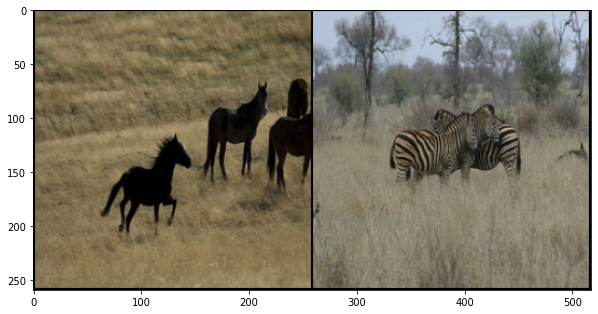

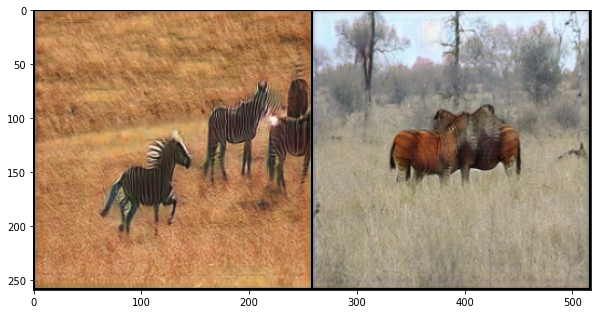

KeyboardInterrupt: 

In [19]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)


def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            # image_width = image.shape[3]
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) # Update gradients
            disc_A_opt.step() # Update optimizer

            ### Update discriminator B ###
            disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) # Update gradients
            disc_B_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_{cur_step}.pth")
            cur_step += 1
train()